In [1]:
% pylab inline
import os
import time
from scipy.misc import imread, imsave, imresize, fromimage, toimage, imfilter
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave, imread, imresize
import theano.tensor.nnet
import theano.tensor.nnet.neighbours
import theano
import theano.tensor as T
from keras import backend as K
from keras.applications import vgg16
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input
#from keras.models import Model

from project_ulti import kmeans,preprocess_image, deprocess_image, load_mask_labels,gram_matrix

import Maxpooling_layer
from Maxpooling_layer import pool_model
import numpy as np

Populating the interactive namespace from numpy and matplotlib


Using Theano backend.
/Users/xikai_chen/anaconda/lib/python2.7/site-packages/Theano-0.8.2-py2.7.egg/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
# set image paths
root_dir = os.path.abspath('.')

ref_image_path = os.path.join(root_dir, 'style.png')
style_mask_path = os.path.join(root_dir,'style_mask.png')
target_mask_path = os.path.join(root_dir,'target_mask.png')

In [3]:
img_nrows = 400
img_ncols = 400
nb_labels = 4
nb_colors = 3  
style_weight = 1.
region_style_weight=0.4

In [4]:
ref_img = preprocess_image(ref_image_path)

style_image=T.tensor4('style_image')
style_image=ref_img
target_image= T.tensor4('target_image')



raw_style_mask, raw_target_mask = load_mask_labels()
raw_style_mask=raw_style_mask.astype(float32)
raw_target_mask=raw_target_mask.astype(float32)

style_mask = T.tensor4('style_mask')
target_mask =T.tensor4('target_mask')

style_mask=raw_style_mask
target_mask=raw_target_mask
masks = T.concatenate([style_mask, target_mask], axis=0)
input_tensor = T.concatenate([style_image, target_image], axis=0)

In [5]:
'''
In this part, we use vgg16 from keras. And the weights from imagenet, we implement our own vgg-16. But because 
traning a vgg-16 need huge dataset and take very long time. Our model doesen't get a very good result. We mentioned 
this in our report, and our model is in the file my_net.py as well as the weights we have saved. The original vgg-16
weights from imagenet has 500MB. 
'''

model = vgg16.VGG16(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('VGG-16 weights from imagenet')

VGG-16 weights from imagenet


In [6]:
mask_input = Input(tensor=masks, shape=(None, None, None), name="mask_input")  
x = mask_input

In [7]:
'''
In this part, we implement a special model only contains pooling layer. The model is in Maxpooling_layer.py file
'''
pp=pool_model(x)

... building the model


Maxpooling_layer.py:317: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 0 is not part of the computational graph needed to compute the outputs: x.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  on_unused_input='warn'


In [8]:
image_features = {}
mask_features = {}
count = 0
pool = 0
for img_layer in model.layers:
    if 'conv' in img_layer.name:
        layer_name = img_layer.name
        img_feat, mask_feat = img_layer.output, pp[count+pool]
        image_features[layer_name] = img_feat
        mask_features[count+pool] = mask_feat
        count +=1
    else:
        pool+=1
    

In [9]:
def block_loss(style_image, target_image, style_mask, target_mask):

    masked_style = style_image * style_mask
    masked_target = target_image * target_mask
    channels = T.shape(style_image)[0]
    M=T.mean(style_mask)
    N=T.mean(target_mask)
    MS = gram_matrix(masked_style)/M*channels 
    MT = gram_matrix(masked_target)/N*channels

    return T.mean(T.square(MS - MT))

In [10]:
def style_loss(style_image, target_image, style_masks, target_masks):   
 
    loss =theano.shared(numpy.cast[theano.config.floatX](0.), name='loss')
    for i in range(nb_labels):
        style_mask = style_masks[i, :, :]
        target_mask = target_masks[i, :, :]

        loss += region_style_weight * block_loss(style_image, target_image, style_mask, target_mask)
    return loss


In [11]:
style_feature_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1',
                        'block4_conv1', 'block5_conv1']

loss =theano.shared(numpy.cast[theano.config.floatX](0.), name='loss')
count = [1,4,8,12,16]
p=0
for layer in style_feature_layers:
    style_feat = image_features[layer][0, :, :, :]
    target_feat = image_features[layer][1, :, :, :]
    style_masks = mask_features[count[p]][0, :, :, :]
    target_masks = mask_features[count[p]][1, :, :, :]
    sl = style_loss(style_feat, target_feat, style_masks, target_masks)
    loss += (style_weight / len(style_feature_layers)) * sl
    p+=1

In [12]:
grads = T.grad(loss, target_image)

In [13]:
# set output
outputs = [loss]
outputs.append(grads)
f_outputs = theano.function([target_image],outputs,allow_input_downcast=True)

In [14]:
'''
This part conclude eval_loss_and_grads function and Evaluator class. It is a very common helper tool
to show the loss and gradient value. Many papers has mention this code. And we can also find the code
from famous Github: https://github.com/alexjc/neural-doodle. From alexjc the author of the orignal paper 
'Semantic Style Transfer and Turning Two-Bit Doodles into Fine Artwork. Many thanks to Alex J. Champandard
'''
def eval_loss_and_grads(x):
    x = x.reshape((1, 3, img_nrows, img_ncols))
    outs = f_outputs(x)
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        
        self.style=style
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [15]:
x = np.random.uniform(0, 255, (1, 3, img_nrows, img_ncols)) - 128

In [16]:
error=[]
for i in range(4):
    print('Start of iteration', i)
    
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    error.append(min_val)
    if i % 1==0:      
        img = deprocess_image(x.copy())
        fname = '_at_iteration_%d_.png' % i
        imsave(fname, img)
        end_time = time.time()
        print('Image saved as', fname)
   

('Start of iteration', 0)
('Current loss value:', array(5.663743499345021e+20))
('Image saved as', '_at_iteration_0_.png')
('Start of iteration', 1)
('Current loss value:', array(2.34882555809768e+20))
('Image saved as', '_at_iteration_1_.png')
('Start of iteration', 2)
('Current loss value:', array(1.317115733772447e+20))
('Image saved as', '_at_iteration_2_.png')
('Start of iteration', 3)
('Current loss value:', array(8.585180051855663e+19))
('Image saved as', '_at_iteration_3_.png')


In [17]:
img = deprocess_image(x.copy())
fname = '_at_iteration_%d_.png' % 20
imsave(fname, img)

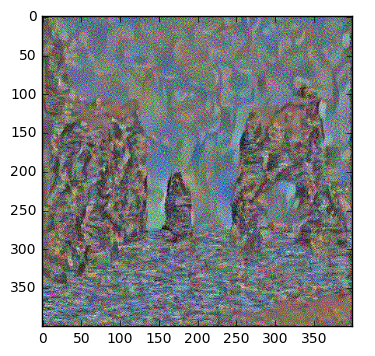

In [18]:
img = deprocess_image(x.copy())
imshow(img)